# petersen2smiley
    
Since we reached 100% on the test set with the AutoKeras model, we wanted to come up with a creative idea. The plan was as follows:

1. Extract faces of Prof. Petersen from the frames of the recordings of lectures with the FaceNet 
   network (https://github.com/timesler/facenet-pytorch).
2. Convert the smiley numpy arrays into a format we can train our CycleGAN with.
3. Train a petersen2smiley CycleGAN (https://github.com/LynnHo/CycleGAN-Tensorflow-2) between Prof. Petersen 
   and the given smileys.
4. Use the deepface network (https://github.com/serengil/deepface) to classify the expression of the transformed images of Prof. Petersen.

CycleGAN doesn't need a correspondence between the source and target domain, which fits our situation. The idea of CycleGAN is to learn a mapping $G: X \rightarrow Y$ where the distribution of images betwen $Y$ and $G(X)$ is indistinguishable.

The main problem that arose with this type of generative adversarial network is the very long training time to even get reasonable results. We trained only on one middle class GPU for some hours.

### Imports

In [1]:
import numpy as np
from facenet_pytorch import MTCNN
from deepface import DeepFace
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from IPython import display

smileys = np.load("data_train_Facial.npy", allow_pickle = True)
smiley_count = smileys.shape[0]

video = cv2.VideoCapture("lectures.mp4")
video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

image_size = 256

### Extract Faces from Lectures

In [ ]:
# create face detector
mtcnn = MTCNN(image_size = image_size, margin = 40, select_largest = False, post_process = False)

# loop through video frames
for frame_number in tqdm(range(video_length)):
    
    # load frame
    success, frame = video.read()
    if not success:
        continue
        
    # convert to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # save face
    mtcnn(frame, save_path = f"CycleGAN\\datasets\\petersen2smiley\\trainB\\face_{frame_number:05d}.png")

### Save Smileys as Images

In [ ]:
for index in tqdm(range(smiley_count)):
    
    smiley = np.uint8(smileys[index])
    
    # create empty image
    image = Image.new(mode = "RGB", size = smiley.shape)
    pixels = image.load()
    
    # loop through pixels
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            
            # set pixel to white
            if smiley[i,j] == 0:
                pixels[j,i] = (255, 255, 255)
                
            # set pixel to yellow
            elif smiley[i,j] == 1:
                pixels[j,i] = (255, 255, 0)
                
            # else pixels are black
    
    image = image.resize((image_size, image_size))
    
    # save smiley image
    image.save(f"CycleGAN\\datasets\\petersen2smiley\\trainA\\smiley_{index:05d}.png")

### Train CycleGAN

We trained the CycleGAN for a few hours with these images in their separate folders using the command `python train.py --dataset petersen2smiley` and produced the examples with `python test.py --experiment_dir ./output/petersen2smiley`.

### Expression Classifier
Now that we have the transformed images we can let deepface classify the expressions. First though we will see that deepface cannot directly classify the emotions in smileys.

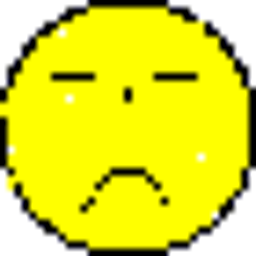

In [2]:
display.Image(f"examples\\smiley_0.png")

In [3]:
DeepFace.analyze(img_path = "examples\\smiley_0.png", actions = ["emotion"])

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.

In [4]:
def classify(index):
    analytics = DeepFace.analyze(img_path = f"examples\\face_{index}.png", actions = ["age", "gender", "race", "emotion"])
    print("age:", analytics["age"])
    print("gender:", analytics["gender"])
    print("dominant race:", analytics["dominant_race"])
    print("dominant emotion:", analytics["dominant_emotion"])
    if index != 0:
        return display.Image(f"examples\\test_{index}.png")
    return display.Image(f"examples\\face_{index}.png")

Let's see how deepface classifies a non-transformed face of Prof. Petersen for comparison.

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/it]

age: 23
gender: Man
dominant race: middle eastern
dominant emotion: angry


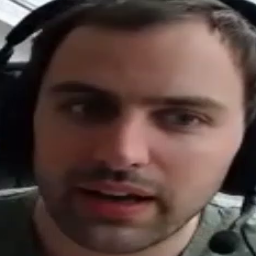

In [5]:
classify(0)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.25s/it]

age: 25
gender: Man
dominant race: white
dominant emotion: angry


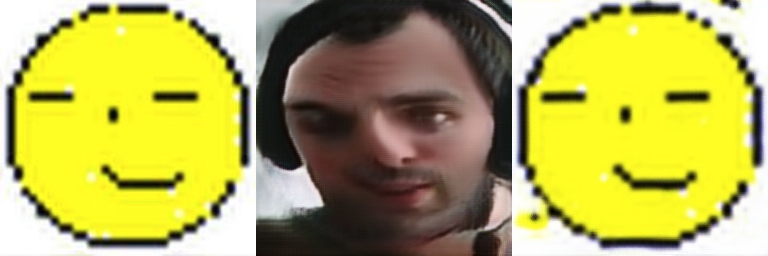

In [6]:
classify(1)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]

age: 29
gender: Man
dominant race: white
dominant emotion: happy


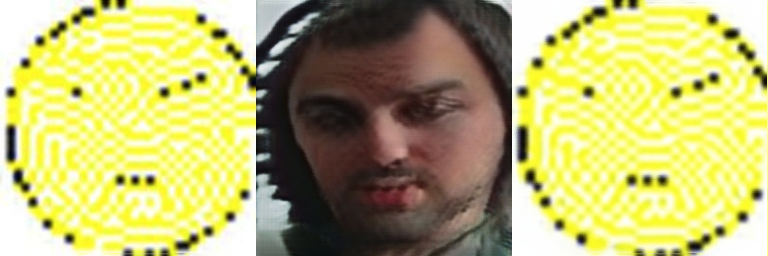

In [7]:
classify(2)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.25s/it]

age: 24
gender: Man
dominant race: white
dominant emotion: happy


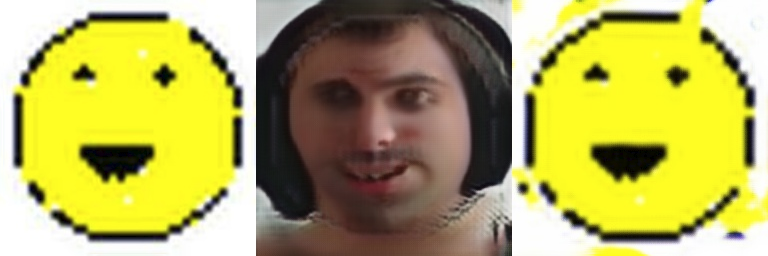

In [8]:
classify(3)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]

age: 25
gender: Man
dominant race: white
dominant emotion: happy


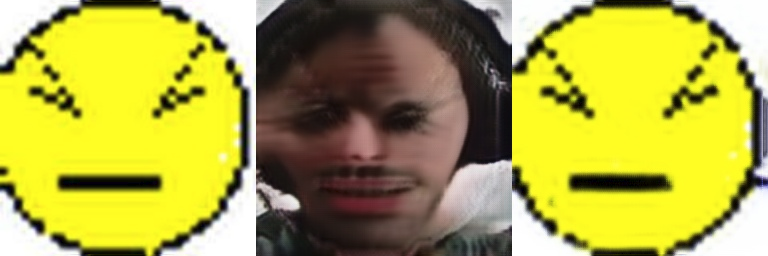

In [9]:
classify(4)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.32s/it]

age: 31
gender: Man
dominant race: white
dominant emotion: sad


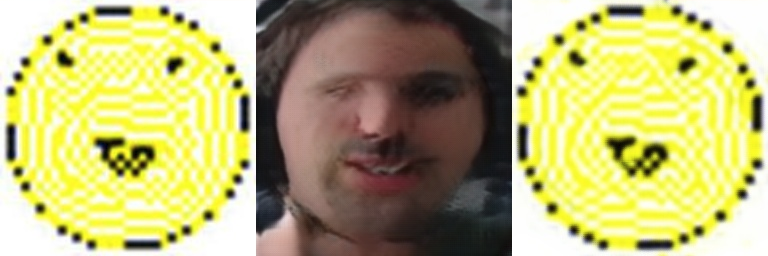

In [10]:
classify(5)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

age: 25
gender: Man
dominant race: white
dominant emotion: happy


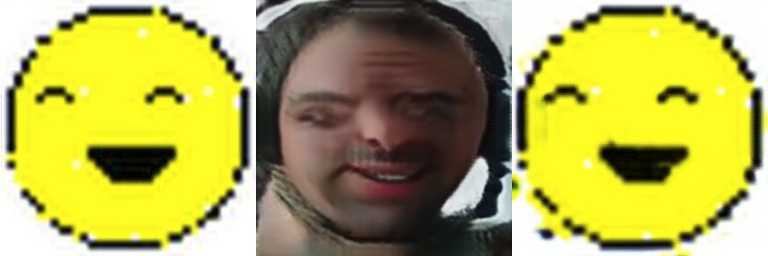

In [11]:
classify(6)

Action: emotion: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]

age: 25
gender: Man
dominant race: asian
dominant emotion: sad


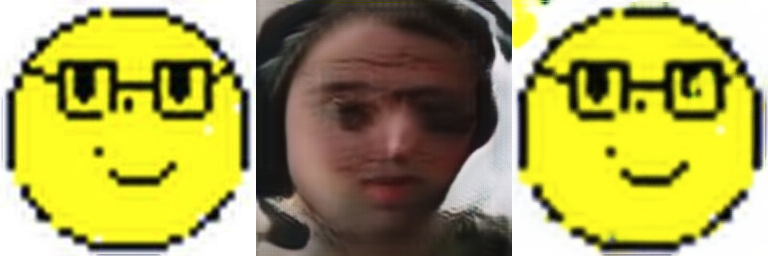

In [12]:
classify(7)